# Wasserstein measure

In [74]:
import pickle as pk
import sys
import time
from pathlib import Path

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch
from mpl_toolkits.mplot3d import Axes3D
from numpy import arccos, array, clip
from src.ri_distances.eval_predictor import (
    display_predictor_metrics_vs_pnt_cloud_size, evaluate_predictor, plot_metric,
    plot_time)
from src.ri_distances.pnt_cloud_generation import (get_gaussian_point_cloud,
                                                   get_spiral)
from src.ri_distances.rotation_predictor import WS
from src.ri_distances.SGW.sgw import get_data, get_P, get_rot
from src.ri_distances.SGW.sgw_pytorch import sgw_gpu_np
from tqdm import tqdm, trange

plt.style.use('ggplot')

torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import pickle as pk
from dataclasses import dataclass

import pandas as pd
from se3_transformer_pytorch.irr_repr import rot
from src.ri_distances.eval_data_param import (DataParam,
                                              display_metric_vs_time_results,
                                              load_most_recent)
from src.ri_distances.icp.icp import IcpPredictor
from src.ri_distances.pnt_cloud_generation import (generate_permutation_matrix,
                                                   generate_rotation_matrix)
from src.ri_distances.SGW.risgw import (RisgwPredictor, risgw_gpu,
                                        train_and_get_RISGW_affine_map)
from src.ri_distances.SGW.sgw_pytorch import sgw_gpu
from src.se3.visualization import viz_point_cloud, viz_point_cloud_2d, viz_src_trgt

import wandb


## Point cloud Visualization

We visualize the noise amplitude to get a visual feeling

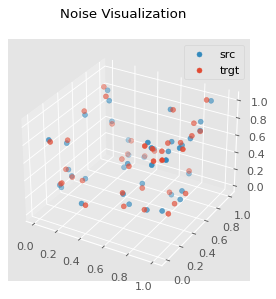

In [8]:
p = DataParam(N_pts=40,noise_factor=0.03,data_func=get_gaussian_point_cloud,theta=0)
src_pnt_cloud,_ ,trgt_pnt_cloud= p.generate_target()
fig = viz_point_cloud([(src_pnt_cloud,'src'),
                       (trgt_pnt_cloud,'trgt'),
                     ])
fig.suptitle('Noise Visualization')
fig

## Point Cloud alignment

We display one cell per alignment method: the same code runs to generate the plot when running `python src/ri_distances/eval_data_param.py`

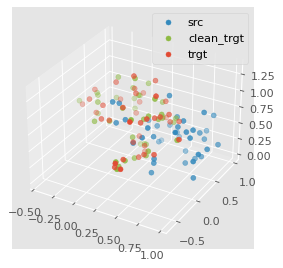

In [17]:
# Visualizaton of the target point cloud
p = DataParam(N_pts=40,noise_factor=0.04,data_func=get_gaussian_point_cloud)
src_pnt_cloud,clean_trgt,trgt_pnt_cloud= p.generate_target()
viz_point_cloud([(src_pnt_cloud,'src'),
                 (clean_trgt,'clean_trgt'),
                 (trgt_pnt_cloud,'trgt'),
                     ])

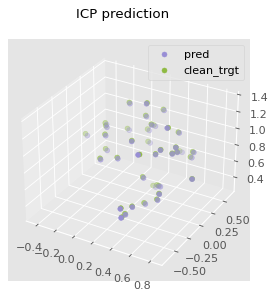

In [18]:
# (1) ICP alignment
predictor = IcpPredictor(max_iter=100,N_rots=100) 
pred_pnts = predictor.predict(src_pnt_cloud,trgt_pnt_cloud)
fig = viz_point_cloud([(pred_pnts,'pred'),
                       (clean_trgt,'clean_trgt'),
                     ])
fig.suptitle("ICP prediction")
fig

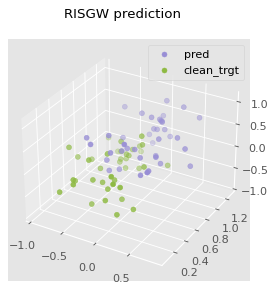

In [7]:
# (2) RISGW alignment
predictor = RisgwPredictor(max_iter=400)
pred_pnts = predictor.predict(src_pnt_cloud,trgt_pnt_cloud)
fig = viz_point_cloud([(pred_pnts,'pred'),
                       (clean_trgt,'clean_trgt'),
                     ])
fig.suptitle("RISGW prediction")
fig

We check whether the inferred permutation is consistent by plotting the first N points

In [90]:
# viz_point_cloud([(pred_pnts[:50],'pred'),
#                     (trgt_pnt_cloud[:50],'trgt')
#                      ])

## Visualizing performances

Once eval_data_param.py and/or eval_predictor.py were executed, we can visualize the data related to the most recent runs.

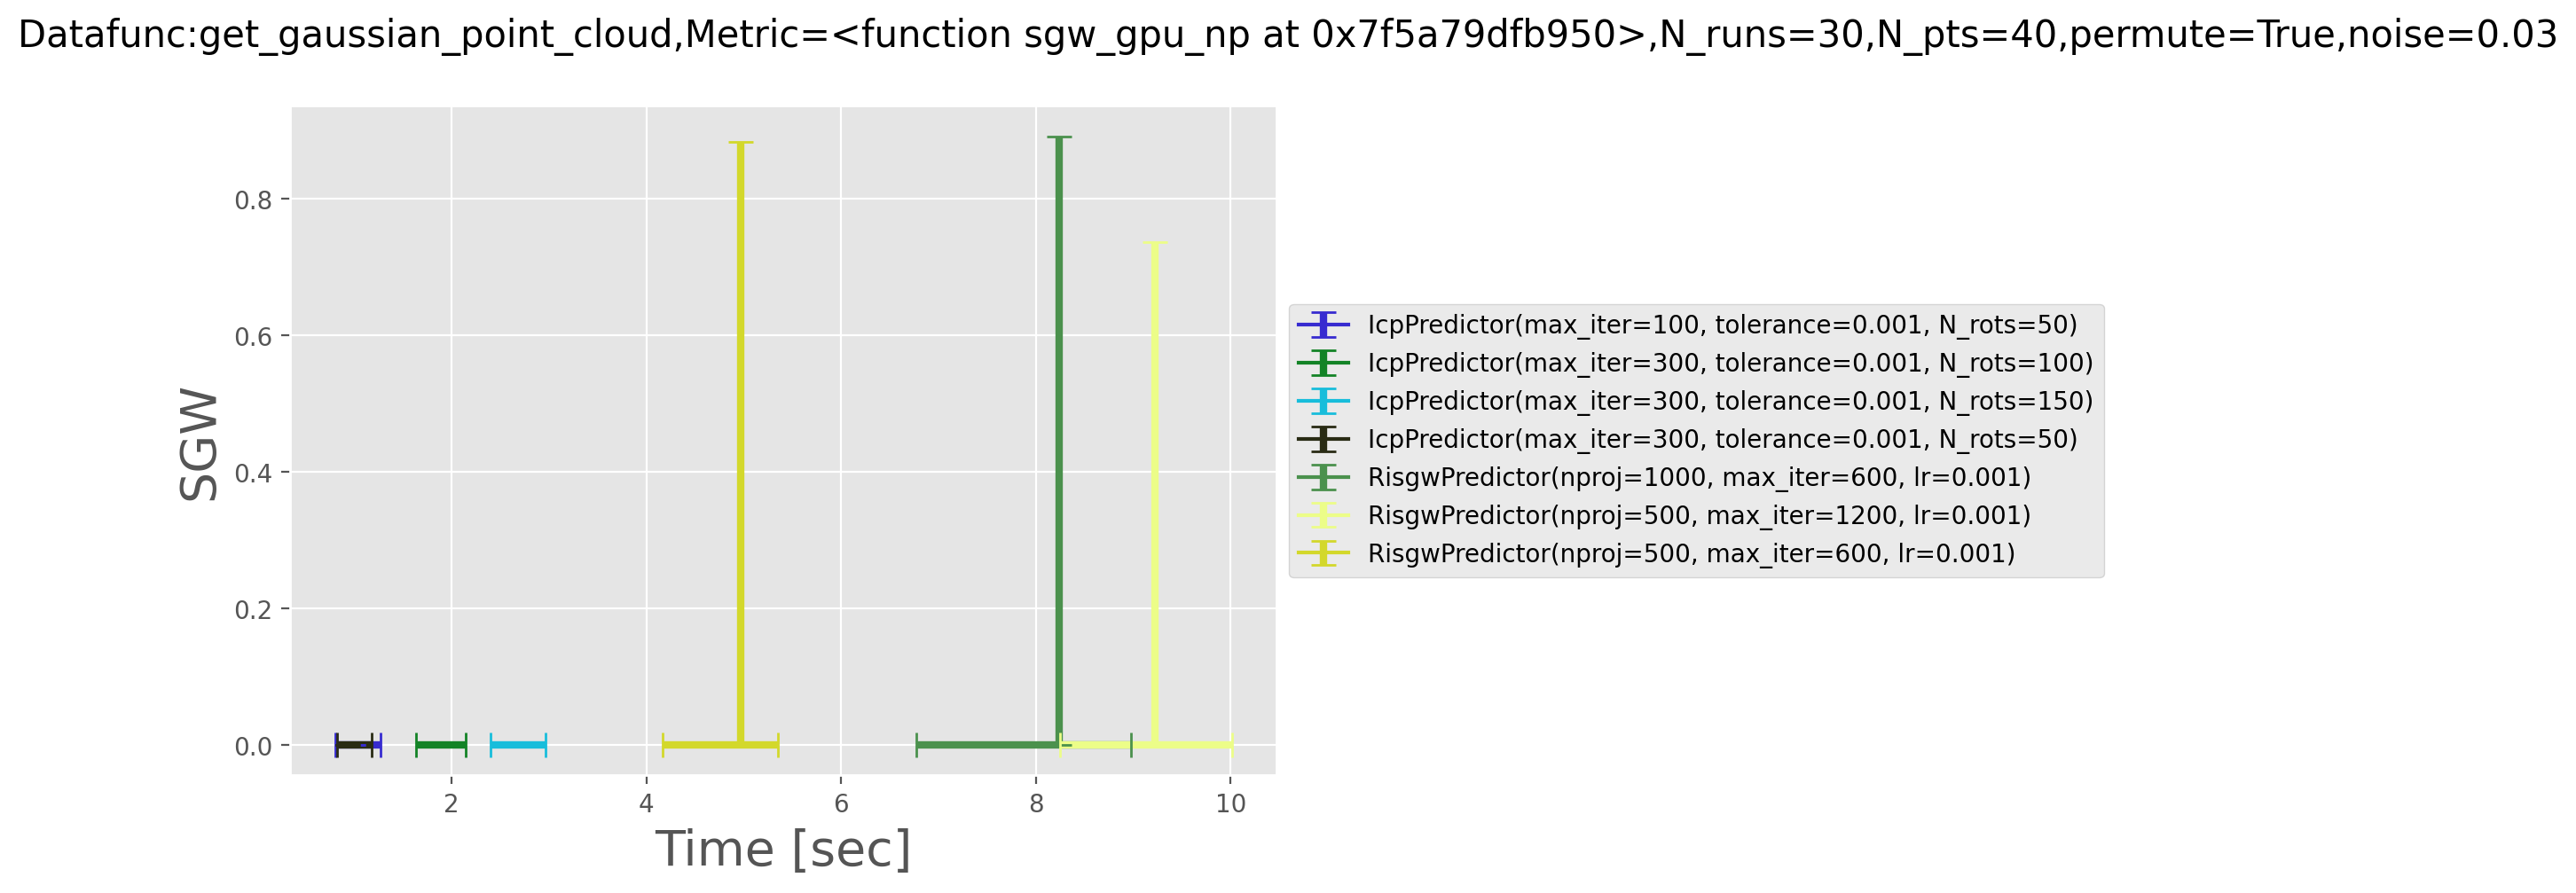

In [26]:
results = load_most_recent(Path("../models/"))


fig,ax = plt.subplots(1,dpi=100,figsize=(15,5))

display_metric_vs_time_results(results,fig,ax)
fig

## Visualizing the performances


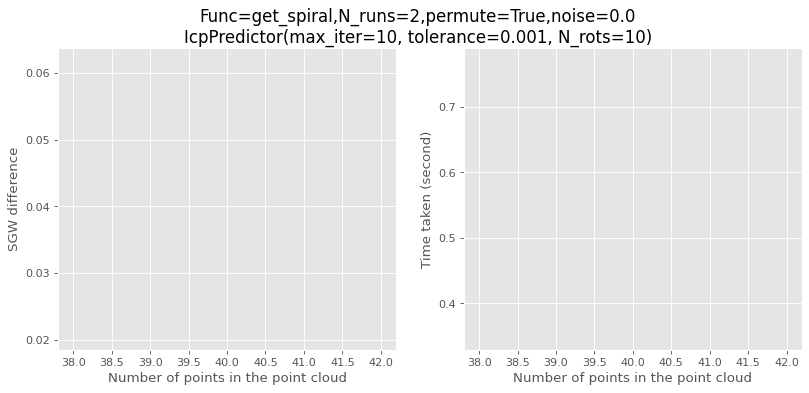

In [26]:
results = load_most_recent(Path("../models/"))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
display_predictor_metrics_vs_pnt_cloud_size(results,fig,axes)

## Rotation invariance

In [83]:
display_dummy_icp_inceritude_plots(thetas,bunny_dummy,bunny_icp,ax,title="gaussian")

In [170]:
fig.savefig("../results/3dataset.png", bbox_inches='tight')